In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import (accuracy_score, confusion_matrix,
                            classification_report, roc_curve, auc, log_loss)
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier, plot_importance, plot_tree
import shap
from hyperopt import hp, fmin, tpe, Trials, STATUS_OK
from sklearn.model_selection import cross_val_score
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Set random seed for reproducibility
np.random.seed(42)

In [3]:
# Load dataset (using the Titanic dataset as example)
url = "https://raw.githubusercontent.com/datasciencedojo/datasets/master/titanic.csv"
data = pd.read_csv(url)

In [4]:
# Display basic info
print("Dataset shape:", data.shape)
print("\nMissing values:")
print(data.isnull().sum())

Dataset shape: (891, 12)

Missing values:
PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64


In [5]:
# Preview data
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [6]:
# Data preprocessing
def preprocess_data(df):
    # Drop columns with too many missing values or not useful
    df = df.drop(['PassengerId', 'Name', 'Ticket', 'Cabin'], axis=1)

    # Fill missing values
    df['Age'] = df['Age'].fillna(df['Age'].median())
    df['Embarked'] = df['Embarked'].fillna(df['Embarked'].mode()[0])

    # Convert categorical variables
    df['Sex'] = LabelEncoder().fit_transform(df['Sex'])
    df = pd.get_dummies(df, columns=['Embarked'], drop_first=True)

    return df

data = preprocess_data(data)

In [7]:
# Split into features and target
X = data.drop('Survived', axis=1)
y = data['Survived']

In [8]:
# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("\nTraining set shape:", X_train.shape)
print("Test set shape:", X_test.shape)


Training set shape: (712, 8)
Test set shape: (179, 8)


In [9]:
# Initialize and train basic XGBoost model
basic_model = XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    use_label_encoder=False,
    random_state=42
)

basic_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, ...)

In [10]:
# Make predictions
y_pred = basic_model.predict(X_test)
y_pred_proba = basic_model.predict_proba(X_test)[:, 1]

In [11]:
# Evaluate model
print("\nBasic Model Evaluation:")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))


Basic Model Evaluation:
Accuracy: 0.8044692737430168

Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.84      0.83       105
           1       0.77      0.76      0.76        74

    accuracy                           0.80       179
   macro avg       0.80      0.80      0.80       179
weighted avg       0.80      0.80      0.80       179


Confusion Matrix:
[[88 17]
 [18 56]]


In [12]:
# Define parameter grid
param_grid = {
    'n_estimators': [100, 150],
    'max_depth': [3, 5],
    'learning_rate': [0.01, 0.1],
    'gamma': [0, 0.1]
}

In [13]:
# Initialize GridSearchCV
grid_search = GridSearchCV(
    estimator=XGBClassifier(
        objective='binary:logistic',
        eval_metric='logloss',
        use_label_encoder=False,
        random_state=42
    ),
    param_grid=param_grid,
    cv=5,
    n_jobs=-1,
    verbose=1
)

In [14]:
# Perform grid search
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [23:59:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [23:59:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [23:59:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [23:59:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False,
                                     eval_metric='logloss', feature_types=None,
                                     feature_weights=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraint...
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None, ...),
             n_jobs=-1,
             param_grid={'gamma': [0, 0.1], 'learning_rate': [0.01, 0.1],
                         'max_depth': [3, 5], 'n_estimators': [100, 150]},
             verbose=1)

In [15]:
# Get best parameters and model
best_params = grid_search.best_params_
tuned_model = grid_search.best_estimator_

print("\nBest Parameters:", best_params)


Best Parameters: {'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}


In [16]:
# Evaluate tuned model
y_pred_tuned = tuned_model.predict(X_test)
print("\nTuned Model Accuracy:", accuracy_score(y_test, y_pred_tuned))


Tuned Model Accuracy: 0.8268156424581006


In [17]:
# Set style for plots
plt.style.use('seaborn-v0_8')

<Figure size 1000x600 with 0 Axes>

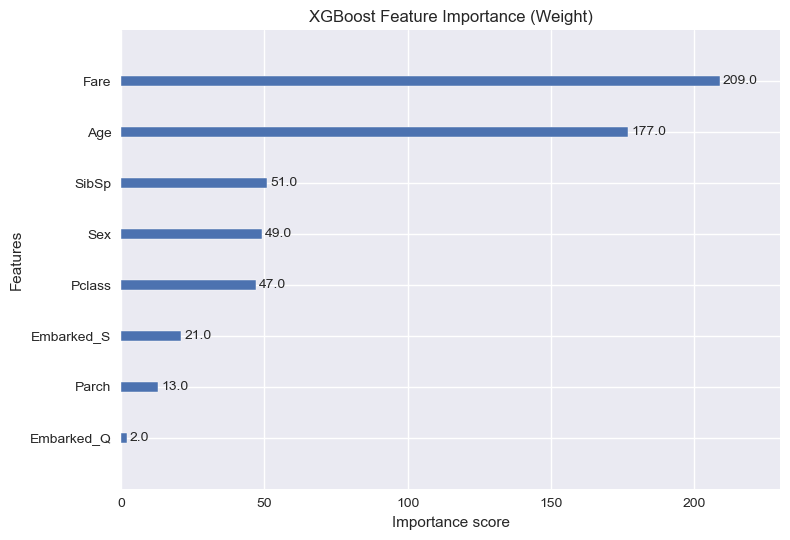

<Figure size 1000x600 with 0 Axes>

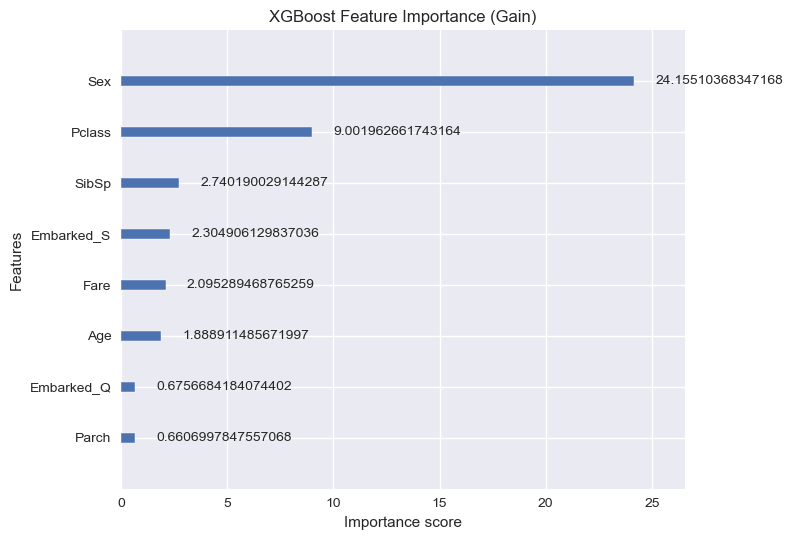

In [18]:
# Feature Importance
plt.figure(figsize=(10, 6))
plot_importance(tuned_model, importance_type='weight')
plt.title('XGBoost Feature Importance (Weight)')
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
plot_importance(tuned_model, importance_type='gain')
plt.title('XGBoost Feature Importance (Gain)')
plt.tight_layout()
plt.show()

<Figure size 2000x1000 with 0 Axes>

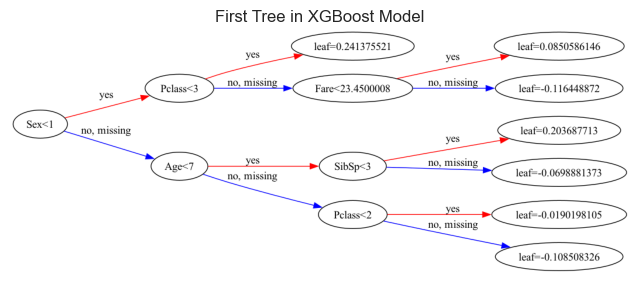

In [20]:
# Single Decision Tree Visualization
plt.figure(figsize=(20, 10))
plot_tree(tuned_model, tree_idx=0, rankdir='LR')
plt.title('First Tree in XGBoost Model')
plt.show()

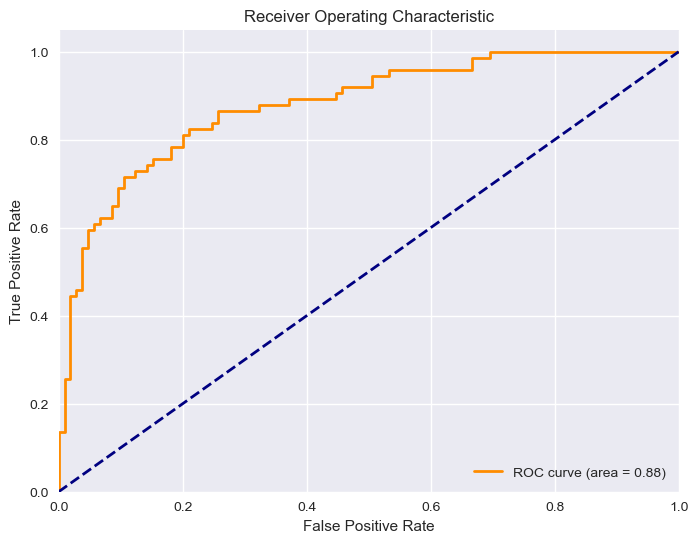

In [21]:
# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [22]:
# SHAP Values for Model Interpretation
explainer = shap.TreeExplainer(tuned_model,
                              feature_perturbation="tree_path_dependent",
                              model_output="raw")

# Calculate SHAP values
shap_values = explainer(X_test)

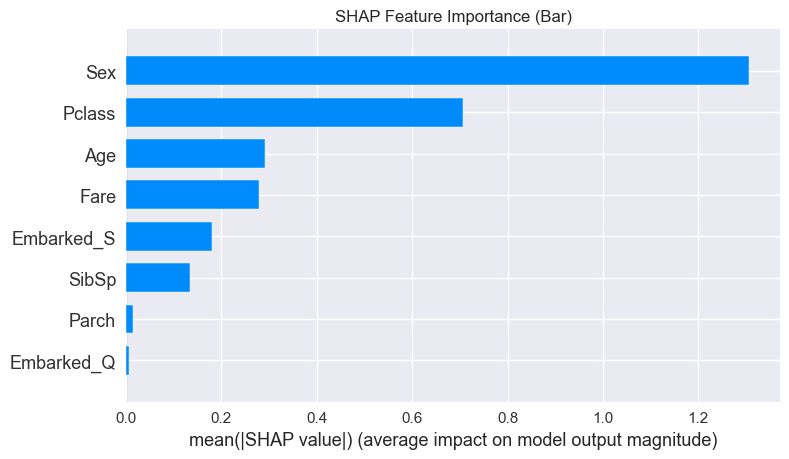

In [23]:
# Plot SHAP summary (bar plot)
plt.figure(figsize=(10, 6))
shap.summary_plot(
    shap_values,
    X_test,
    plot_type="bar",
    show=False
)
plt.title('SHAP Feature Importance (Bar)')
plt.tight_layout()
plt.show()

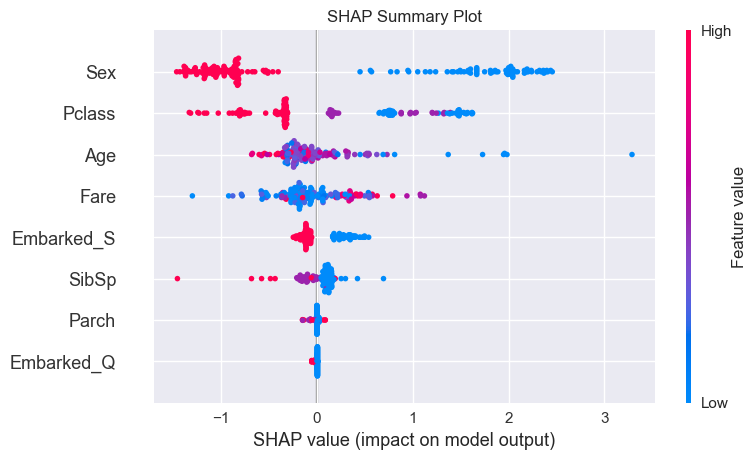

In [24]:
# Plot SHAP summary (dot plot)
plt.figure(figsize=(10, 6))
shap.summary_plot(
    shap_values,
    X_test,
    show=False
)
plt.title('SHAP Summary Plot')
plt.tight_layout()
plt.show()

In [25]:
# Define the search space for Bayesian optimization
space = {
    'n_estimators': hp.quniform('n_estimators', 50, 300, 25),
    'max_depth': hp.quniform('max_depth', 3, 10, 1),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.3)),
    'subsample': hp.uniform('subsample', 0.6, 1.0),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.6, 1.0),
    'gamma': hp.uniform('gamma', 0, 0.5),
    'min_child_weight': hp.quniform('min_child_weight', 1, 10, 1),
    'reg_alpha': hp.uniform('reg_alpha', 0, 1),
    'reg_lambda': hp.uniform('reg_lambda', 0, 1)
}

In [26]:
def objective(params):
    # Convert parameters to appropriate types
    params = {
        'n_estimators': int(params['n_estimators']),
        'max_depth': int(params['max_depth']),
        'learning_rate': params['learning_rate'],
        'subsample': params['subsample'],
        'colsample_bytree': params['colsample_bytree'],
        'gamma': params['gamma'],
        'min_child_weight': params['min_child_weight'],
        'reg_alpha': params['reg_alpha'],
        'reg_lambda': params['reg_lambda'],
        'objective': 'binary:logistic',
        'eval_metric': 'logloss',
        'use_label_encoder': False,
        'random_state': 42
    }

    # Initialize and cross-validate model
    model = XGBClassifier(**params)
    score = cross_val_score(model, X_train, y_train, scoring='neg_log_loss', cv=5).mean()

    # Hyperopt minimizes, so we return negative score
    return {'loss': -score, 'status': STATUS_OK}

In [27]:
# Run optimization
trials = Trials()
best = fmin(
    fn=objective,
    space=space,
    algo=tpe.suggest,
    max_evals=50,
    trials=trials,
    show_progressbar=True
)

100%|██████████| 50/50 [00:05<00:00,  9.13trial/s, best loss: 0.4163705378993191] 


In [28]:
# Get best parameters
bayesian_best_params = {
    'n_estimators': int(best['n_estimators']),
    'max_depth': int(best['max_depth']),
    'learning_rate': best['learning_rate'],
    'subsample': best['subsample'],
    'colsample_bytree': best['colsample_bytree'],
    'gamma': best['gamma'],
    'min_child_weight': best['min_child_weight'],
    'reg_alpha': best['reg_alpha'],
    'reg_lambda': best['reg_lambda']
}

print("Best parameters:", bayesian_best_params)

Best parameters: {'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.04381844727151704, 'subsample': 0.7102548382226718, 'colsample_bytree': 0.9018040568761707, 'gamma': 0.3913952044566616, 'min_child_weight': 2.0, 'reg_alpha': 0.13070849713946972, 'reg_lambda': 0.28251303568714303}


In [29]:
# Initialize and train the model with best parameters
final_model = XGBClassifier(
    **bayesian_best_params,  # Unpack the best parameters
    objective='binary:logistic',
    eval_metric='logloss',
    use_label_encoder=False,
    random_state=42
)

In [30]:
# Train the model
final_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9018040568761707, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='logloss', feature_types=None, feature_weights=None,
              gamma=0.3913952044566616, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.04381844727151704,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=2.0, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, ...)

In [31]:
# Make predictions
y_pred = final_model.predict(X_test)
y_pred_proba = final_model.predict_proba(X_test)[:, 1]  # Probability estimates

In [35]:
# Evaluate model performance
print("\n=== Final Model Evaluation ===")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"Log Loss: {log_loss(y_test, y_pred_proba):.4f}")


=== Final Model Evaluation ===
Accuracy: 0.8101
Log Loss: 0.4100


In [36]:
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.89      0.85       105
           1       0.81      0.70      0.75        74

    accuracy                           0.81       179
   macro avg       0.81      0.79      0.80       179
weighted avg       0.81      0.81      0.81       179



In [37]:
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))


Confusion Matrix:
[[93 12]
 [22 52]]


<Figure size 1000x600 with 0 Axes>

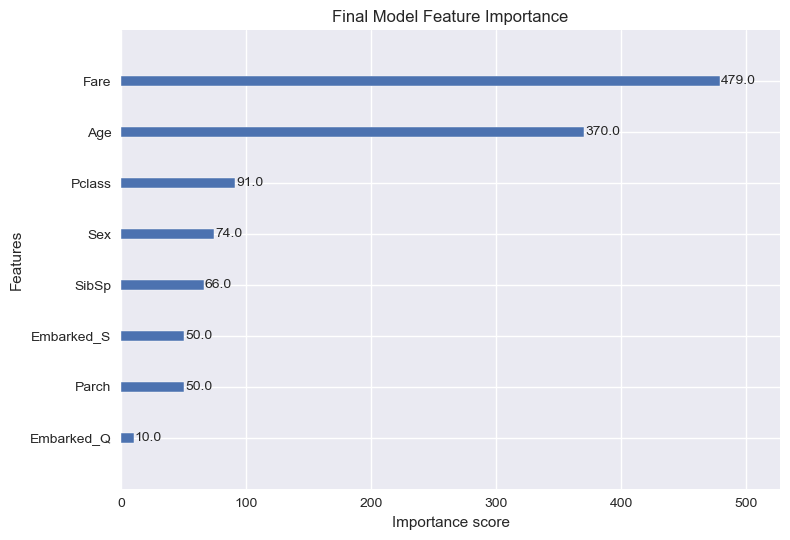

In [38]:
# Plot feature importance
plt.figure(figsize=(10, 6))
plot_importance(final_model, importance_type='weight')
plt.title('Final Model Feature Importance')
plt.tight_layout()
plt.show()

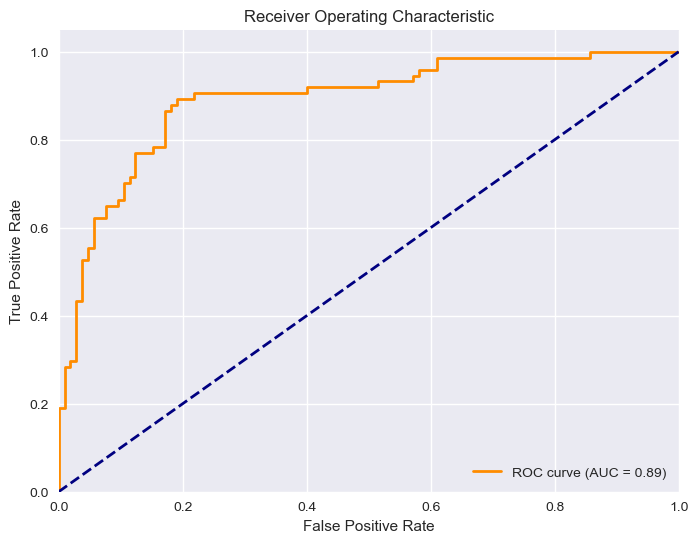

In [39]:
# Plot ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2,
         label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

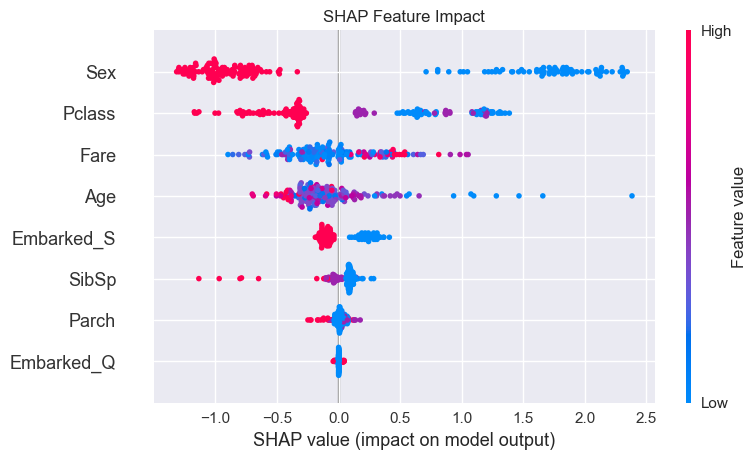

In [40]:
# SHAP summary plot (optional)
explainer = shap.TreeExplainer(final_model)
shap_values = explainer.shap_values(X_test)

plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values, X_test, show=False)
plt.title('SHAP Feature Impact')
plt.tight_layout()
plt.show()